# Import Library & Download Dataset

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
import kagglehub

# Konfigurasi dasar
PIC_SIZE = 48
N_IMAGES_PER_CLASS = 5
DATASET_ID = "jonathanoheix/face-expression-recognition-dataset"

# Download / locate dataset dari Kaggle lewat kagglehub
dataset_path = kagglehub.dataset_download(DATASET_ID)
print("Path to dataset files:", dataset_path)

# Di dalam folder itu ada folder "images/train", "images/validation"
IMAGES_DIR = os.path.join(dataset_path, "images")
TRAIN_DIR = os.path.join(IMAGES_DIR, "train")
VALIDATION_DIR = os.path.join(IMAGES_DIR, "validation")

print("Train dir:", TRAIN_DIR)
print("Validation dir:", VALIDATION_DIR)

Using Colab cache for faster access to the 'face-expression-recognition-dataset' dataset.
Path to dataset files: /kaggle/input/face-expression-recognition-dataset
Train dir: /kaggle/input/face-expression-recognition-dataset/images/train
Validation dir: /kaggle/input/face-expression-recognition-dataset/images/validation


# Display Sample Images

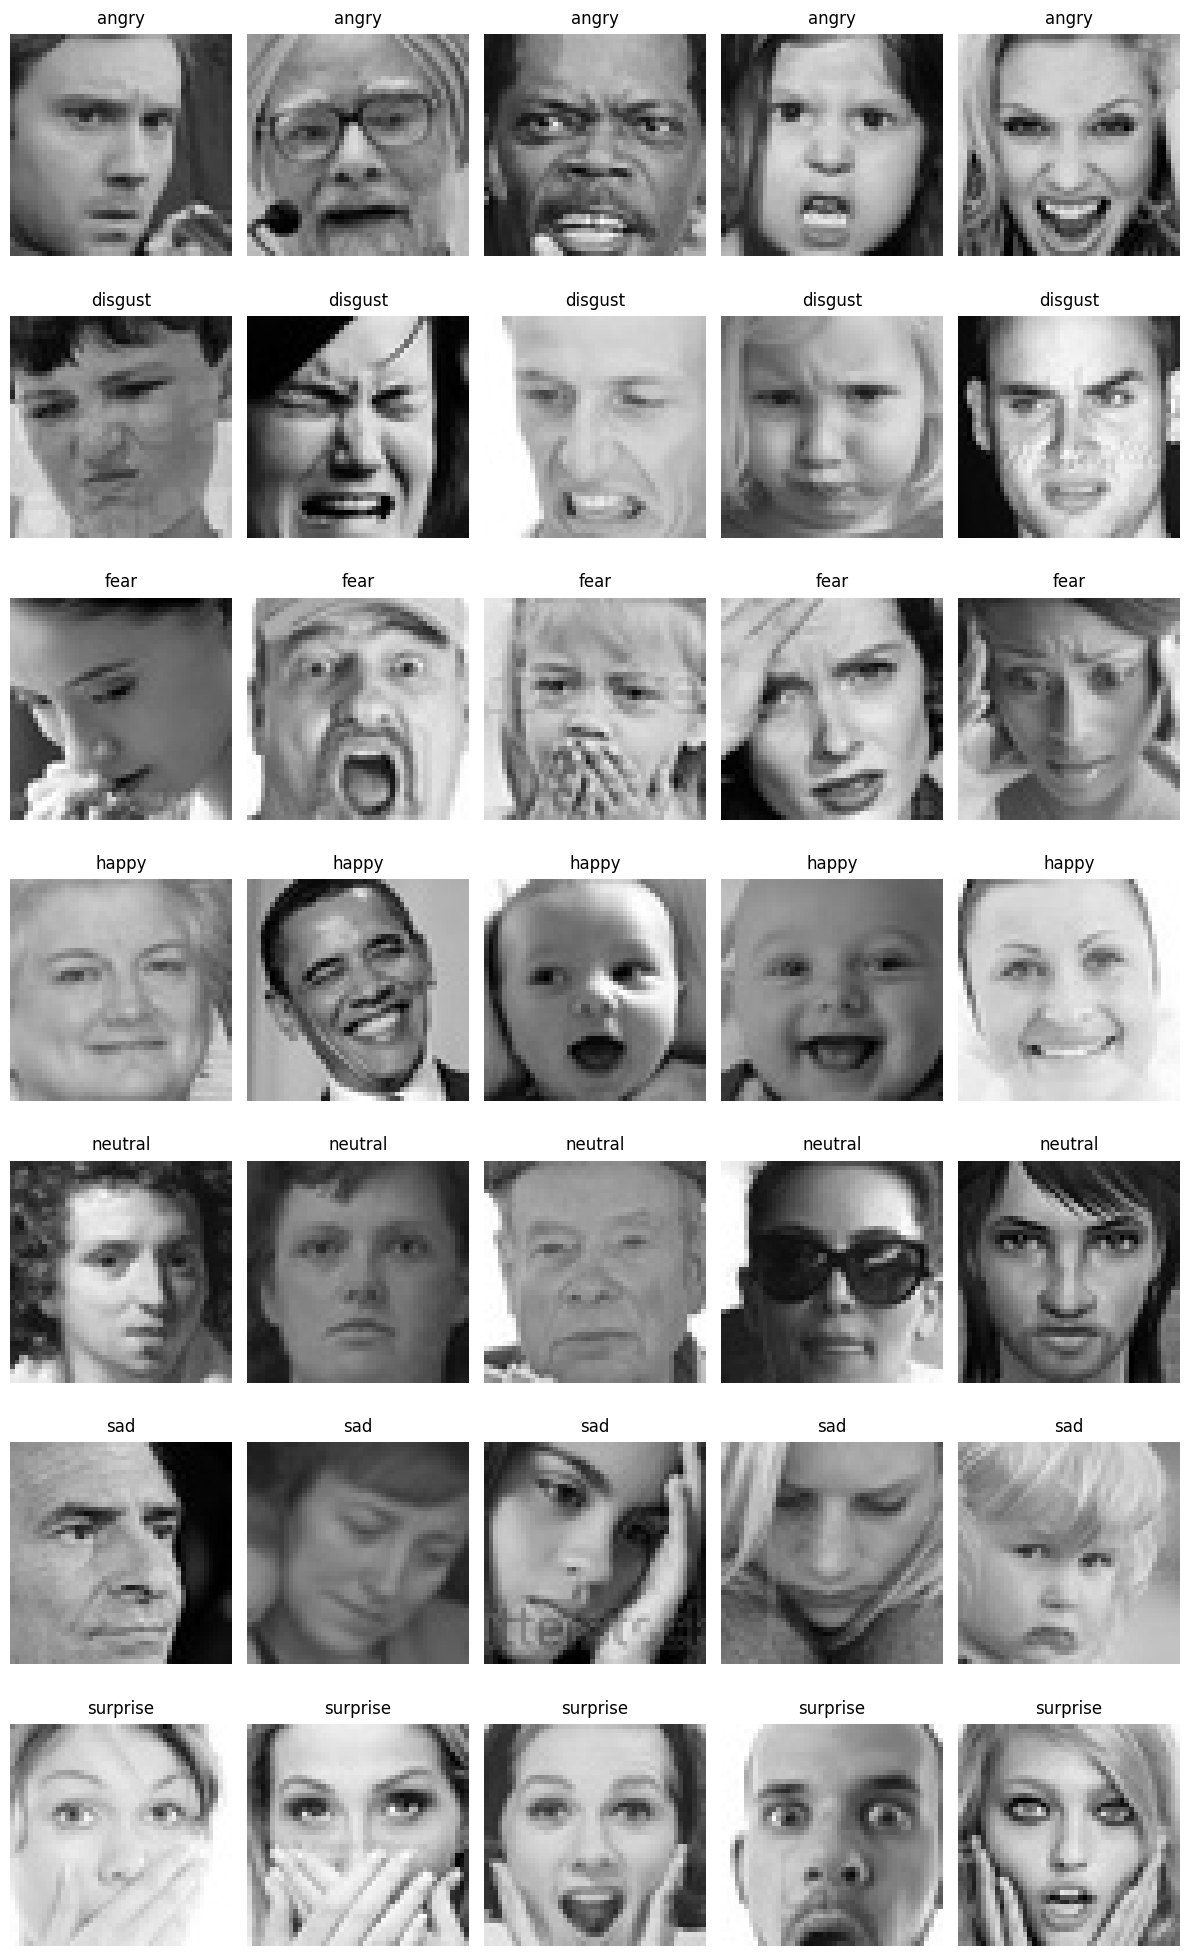

In [ ]:
plt.figure(figsize=(12, 20))

expressions = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

n_classes = len(expressions)
cpt = 1

for expression in expressions:
    expr_dir = os.path.join(TRAIN_DIR, expression)
    image_files = sorted(os.listdir(expr_dir))[:N_IMAGES_PER_CLASS]

    for img_name in image_files:
        img_path = os.path.join(expr_dir, img_name)
        img = load_img(img_path, target_size=(PIC_SIZE, PIC_SIZE))

        plt.subplot(n_classes, N_IMAGES_PER_CLASS, cpt)
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        # label di atas gambar → pasti terlihat
        plt.title(expression, fontsize=12, pad=8)

        cpt += 1

plt.tight_layout()
plt.show()

# Summary Dataframe from Directory Structure

In [ ]:
import pandas as pd

subsets = ["train", "validation"]  # sesuai struktur dataset Kaggle
rows = []

for subset in subsets:
    subset_dir = os.path.join(IMAGES_DIR, subset)
    if not os.path.isdir(subset_dir):
        continue  # skip kalau foldernya nggak ada

    # kelas / kategori ekspresi
    classes = sorted([
        d for d in os.listdir(subset_dir)
        if os.path.isdir(os.path.join(subset_dir, d))
    ])

    for class_name in classes:
        class_dir = os.path.join(subset_dir, class_name)
        n_files = len([
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f))
        ])

        rows.append({
            "Kategori": class_name,
            "Subset": subset.capitalize(),  # "Train" / "Validation"
            "Jumlah File": n_files
        })

df_split = pd.DataFrame(rows)
df_split

,Kategori,Subset,Jumlah File
0,angry,Train,3993
1,disgust,Train,436
2,fear,Train,4103
3,happy,Train,7164
4,neutral,Train,4982
5,sad,Train,4938
6,surprise,Train,3205
7,angry,Validation,960
8,disgust,Validation,111
9,fear,Validation,1018


# Dataset Distribution

/tmp/ipython-input-3880962259.py:19: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  bar = sns.barplot(


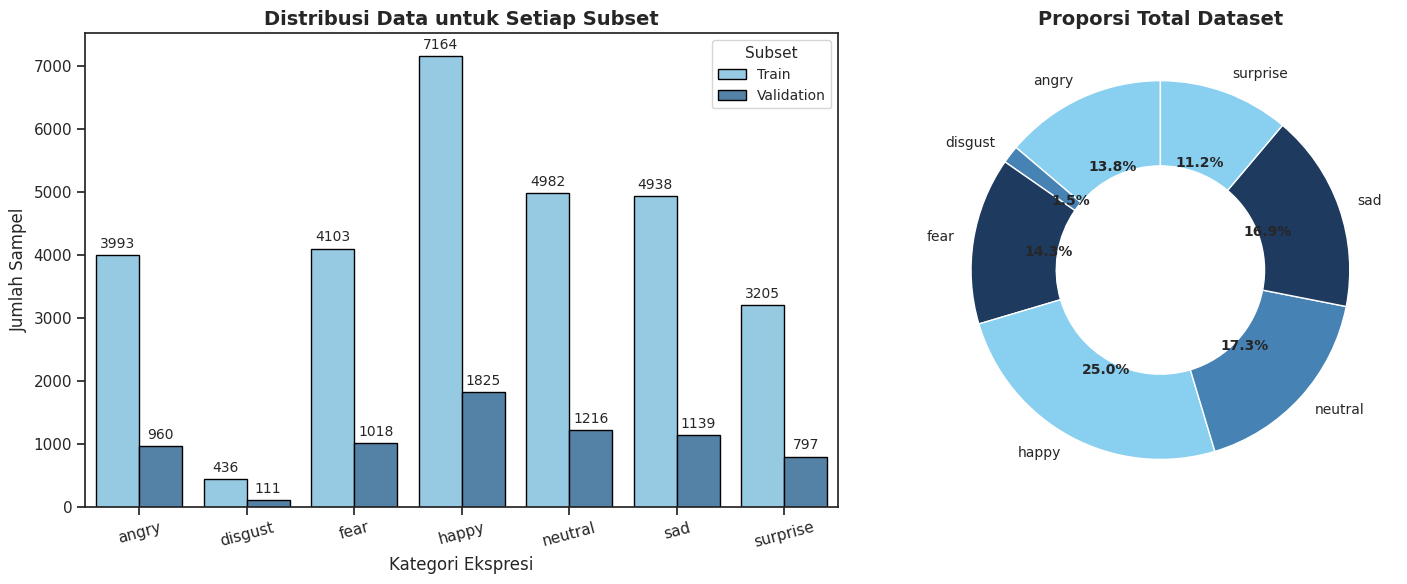

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# tema visual biru elegan
custom_palette = ["#89CFF0", "#4682B4", "#1E3A5F"]

sns.set_theme(style="ticks")
plt.rcParams["font.family"] = "DejaVu Sans"

# setup figure
fig, axes = plt.subplots(
    1,
    2,
    figsize=(15, 6),
    gridspec_kw={'width_ratios': [1.2, 1]}
)

# bar chart
bar = sns.barplot(
    data=df_split,
    x="Kategori",
    y="Jumlah File",
    hue="Subset",
    palette=custom_palette,
    ax=axes[0],
    edgecolor="black"
)

axes[0].set_title("Distribusi Data untuk Setiap Subset", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Kategori Ekspresi", fontsize=12)
axes[0].set_ylabel("Jumlah Sampel", fontsize=12)
axes[0].tick_params(axis="x", rotation=15)

for container in bar.containers:
    bar.bar_label(container, fontsize=10, padding=3)

axes[0].legend(title="Subset", fontsize=10, title_fontsize=11)

# donut chart
kategori_summary = df_split.groupby("Kategori")["Jumlah File"].sum()

wedges, texts, autotexts = axes[1].pie(
    kategori_summary,
    labels=kategori_summary.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette(custom_palette, n_colors=len(kategori_summary)),
    wedgeprops={"width": 0.45}
)

# styling label
plt.setp(autotexts, size=10, weight="bold")
plt.setp(texts, size=10)

axes[1].set_title("Proporsi Total Dataset", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

# ImageDataGenerator for Training & Validation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128
PIC_SIZE = 48

datagen_train = ImageDataGenerator(
    rescale=1./255
)

datagen_validation = ImageDataGenerator(
    rescale=1./255
)

train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,                                # bukan base_path + "train"
    target_size=(PIC_SIZE, PIC_SIZE),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen_validation.flow_from_directory(
    VALIDATION_DIR,                           # bukan base_path + "validation"
    target_size=(PIC_SIZE, PIC_SIZE),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Build CNN model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values – ambil dari generator (harusnya = 7)
nb_classes = train_generator.num_classes

# initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(
    64, (3, 3),
    padding='same',
    input_shape=(PIC_SIZE, PIC_SIZE, 1)
))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flattening
model.add(Flatten())

# fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# output layer
model.add(Dense(nb_classes, activation='softmax'))

# optimizer
opt = Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
import os
from tensorflow.keras import callbacks

# path model terbaik
checkpoint_dir = "/content/drive/MyDrive/arya/models"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, "model-cnn-fer.keras")

# callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',      # simpan model terbaik berdasarkan val_accuracy
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',          # turunkan learning rate jika val_loss stagnan
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',          # hentikan training jika val_loss stagnan
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

# max epoch
EPOCHS = 50

# proses training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

print("✅ Training selesai. Model terbaik disimpan di:", checkpoint_path)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.2043 - loss: 2.1293
Epoch 1: val_accuracy improved from -inf to 0.17266, saving model to /content/drive/MyDrive/arya/models/model-cnn-fer.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 128s 490ms/step - accuracy: 0.2044 - loss: 2.1288 - val_accuracy: 0.1727 - val_loss: 1.8588 - learning_rate: 1.0000e-04
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2736 - loss: 1.8669
Epoch 2: val_accuracy improved from 0.17266 to 0.26946, saving model to /content/drive/MyDrive/arya/models/model-cnn-fer.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.2737 - loss: 1.8668 - val_accuracy: 0.2695 - val_loss: 1.8158 - learning_rate: 1.0000e-04
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3214 - loss: 1.7630
Epoch 3: val_accuracy improved from 0.26946 to 0.31998, saving model to /content/drive/MyDrive/arya/models/model-cnn-fer.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.3215

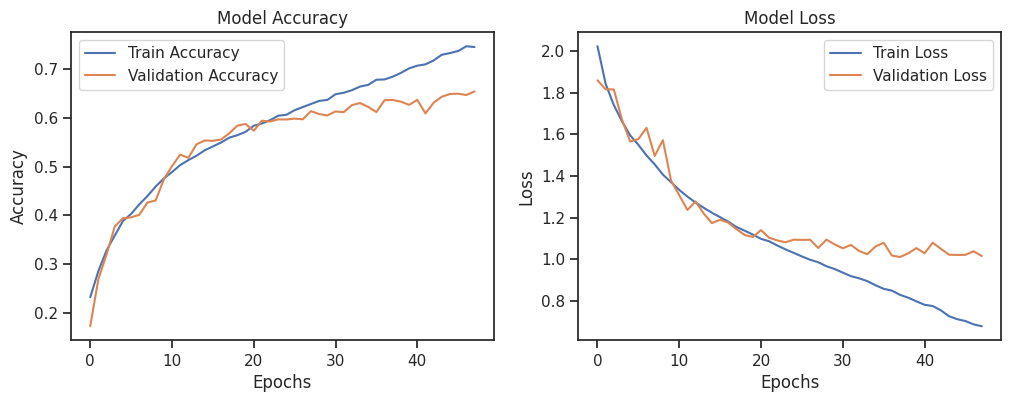

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.52      0.58      0.54       960
     disgust       0.59      0.59      0.59       111
        fear       0.60      0.34      0.44      1018
       happy       0.81      0.86      0.84      1825
     neutral       0.60      0.55      0.57      1216
         sad       0.48      0.59      0.53      1139
    surprise       0.73      0.78      0.75       797

    accuracy                           0.64      7066
   macro avg       0.62      0.61      0.61      7066
weighted avg       0.64      0.64      0.63      7066



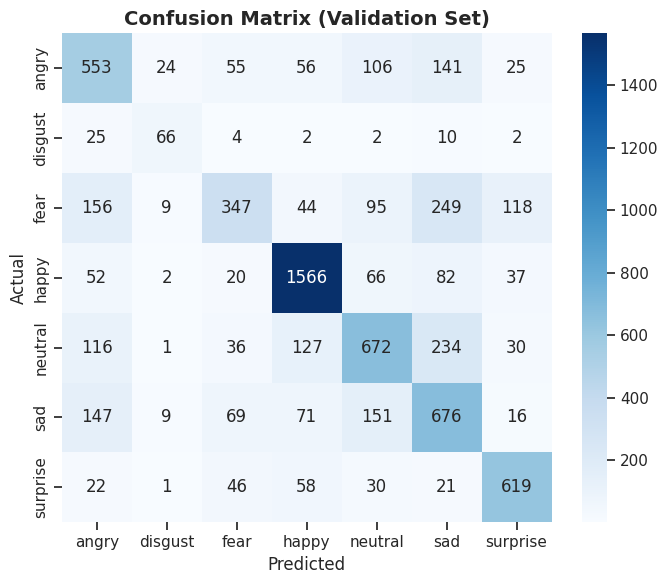

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

validation_generator.reset()

# prediksi
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# label asli
y_true = validation_generator.classes  # otomatis sudah urut sesuai shuffle=False

# mapping kelas indeks
class_indices = validation_generator.class_indices       # dict: class_name -> index
idx_to_class = {v: k for k, v in class_indices.items()}  # invert
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# classification report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=target_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix (Validation Set)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()